In [ ]:
pip install indic-nlp-library

In [ ]:
import json
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer 
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import multiprocessing
import time
import pandas as pd
cores = multiprocessing.cpu_count()

import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('indian')

from indicnlp.tokenize import indic_tokenize

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',None)
import collections
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Package indian is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
caption_comments_replies = open("drive/MyDrive/Dataset/HindiDataset.json",encoding='utf-8')
caption_comments_replies = json.load(caption_comments_replies)

In [ ]:
caption_comments_replies_test = open("drive/MyDrive/Dataset/TestHindi.json",encoding='utf-8')
caption_comments_replies_test = json.load(caption_comments_replies_test)

In [ ]:
len(caption_comments_replies)

92

In [ ]:
len(caption_comments_replies_test)

92

In [ ]:
def tokenization(text):
    tokens = []
    for t in indic_tokenize.trivial_tokenize(text):
        tokens.append(t)
    return tokens

In [ ]:
def get_hindi_words(text):

    temp=''
    for char in text:
        if ord(u'\u0900') <= ord(char) <= ord(u'\u097F') or ord(char)==32:
              temp+=char
              
    return temp.rstrip()

In [ ]:
def remove_stopwords():
    stopwords = set()

    Hindi_Stopwords = open("drive/MyDrive/Dataset/final_stopwords.txt",'r',encoding='utf-8')
    for i in Hindi_Stopwords.readlines():
        stopwords.add(i.rstrip())

    return list(stopwords)

stopwords = remove_stopwords()

In [ ]:
def preprocess_text(text):

    cleaned_hindi_text = get_hindi_words(text)

    word_tokens = tokenization(cleaned_hindi_text)

    # print(len(word_tokens))

    hindi_words = [w for w in word_tokens if not w in stopwords]

    # print(len(hindi_words))

    return word_tokens

# preprocess_text('कोई फोकट का क्यू खिलाएगा कही से तो काटेगा 😂😂😂 Hi How are you?>>.jhgtf')

In [ ]:
def preprocess_text_bert(text):

    cleaned_hindi_text = get_hindi_words(text)

    word_tokens = tokenization(cleaned_hindi_text)

    return word_tokens

In [ ]:
def get_captions_and_comments(index):
    
    caption = caption_comments_replies[index]['content']
    comments = caption_comments_replies[index]['comments_and_replies']
    
    return caption,comments

In [ ]:
def get_captions_and_comments_test(index):
    
    caption = caption_comments_replies_test[index]['content']
    comments = caption_comments_replies_test[index]['comments_and_replies']
    
    return caption,comments

In [ ]:
all_captions_and_comments = []

def iterate_all_captions_and_comments(total_posts,total_comments):
    try:
        for index in range(len(caption_comments_replies)):  
            caption,comments = get_captions_and_comments(index)
            
            all_comments_and_relpies=[]
            labels_comments=[]  

            for i in comments:
                
                all_comments_and_relpies.append(i['comment'])
                labels_comments.append(i['related'])
                
                for j in i['replies']:
                    all_comments_and_relpies.extend((list(j.keys())))
                    labels_comments.extend((list(j.values())))
            documents=[]
            
            filtered_caption = preprocess_text(caption)
            filtered_caption_bert = preprocess_text_bert(caption)


            filtered_caption = ' '.join(filtered_caption)
            filtered_caption_bert = ' '.join(filtered_caption_bert)

            
            filtered_comments=[]
            filtered_comments_labels = []
            
            for idx in range(len(all_comments_and_relpies)):
                cur_comment = preprocess_text(all_comments_and_relpies[idx])
                cur_comment_bert = preprocess_text_bert(all_comments_and_relpies[idx])
                # remove the comment if length is <= 2
                # drop all the words with single character
                if len(cur_comment) > 2:
                    cur_comment = ' '.join( [word for word in cur_comment if len(word)>1 ] )
                    cur_comment_bert = ' '.join( [word for word in cur_comment_bert ] )
                    filtered_comments.append([ index+1 , filtered_caption ,filtered_caption_bert, cur_comment ,cur_comment_bert, labels_comments[idx] ])
                    # filtered_comments_labels.append(labels_comments[idx])
            
            documents.extend(filtered_comments)
                
            all_captions_and_comments.extend(documents)
            total_posts += 1 
            total_comments += len(filtered_comments)
    except Exception as e:
        print(e)
        # print(index)
        # print(all_comments_and_relpies[idx])
        print(caption_comments_replies[index])
    finally:
        return total_posts,total_comments

    
total_posts,total_comments = iterate_all_captions_and_comments(total_posts=0,total_comments=0)

print("\nTotal Posts : {}\n".format(total_posts))
print("\nTotal Comments : {}\n".format(total_comments))
# print("For 1st post :\nCaption : {}\nComments :\n".format(all_captions_and_comments[0][0] ) )
# for i in range(1,len(all_captions_and_comments[0])):
#     print("{}. {}".format(i,all_captions_and_comments[0][i]) )

df = pd.DataFrame( all_captions_and_comments , columns = ['post_number' , 'caption' , 'caption_bert', 'comment' , 'comment_bert', 'label' ]  )  


Total Posts : 92


Total Comments : 3173



In [ ]:
all_captions_and_comments_test = []

def iterate_all_captions_and_comments_test(total_posts_test,total_comments_test):
    try:
        for index in range(len(caption_comments_replies_test)):  
            caption_test,comments_test = get_captions_and_comments_test(index)
            
            all_comments_and_relpies_test = [] 

            for i in comments_test:
                
                all_comments_and_relpies_test.append(i['comment'])
                all_comments_and_relpies_test.extend(i['replies'])

            documents=[]
            
            filtered_caption_test = preprocess_text(caption_test)
            filtered_caption_bert_test = preprocess_text_bert(caption_test)


            filtered_caption_test = ' '.join(filtered_caption_test)
            filtered_caption_bert_test = ' '.join(filtered_caption_bert_test)

            
            filtered_comments_test = []
            
            for idx in range(len(all_comments_and_relpies_test)):
                cur_comment = preprocess_text(all_comments_and_relpies_test[idx])
                cur_comment_bert = preprocess_text_bert(all_comments_and_relpies_test[idx])
                # remove the comment if length is <= 2
                # drop all the words with single character
                if len(cur_comment) > 2:
                    cur_comment_test = ' '.join( [word for word in cur_comment if len(word)>1 ] )
                    cur_comment_bert_test = ' '.join( [word for word in cur_comment_bert ] )
                    filtered_comments_test.append([ index+1 , filtered_caption_test ,filtered_caption_bert_test, cur_comment_test ,cur_comment_bert_test ])
            
            documents.extend(filtered_comments_test)
                
            all_captions_and_comments_test.extend(documents)
            total_posts_test += 1 
            total_comments_test += len(filtered_comments_test)

    except Exception as e:
        print(e)
        print(index)
        # print(all_comments_and_relpies[idx])
        print(caption_comments_replies[index])
    finally:
        return total_posts_test,total_comments_test

    
total_posts_test,total_comments_test = iterate_all_captions_and_comments_test(total_posts_test=0,total_comments_test=0)

print("\nTotal Posts : {}\n".format(total_posts_test))
print("\nTotal Comments : {}\n".format(total_comments_test))
# print("For 1st post :\nCaption : {}\nComments :\n".format(all_captions_and_comments[0][0] ) )
# for i in range(1,len(all_captions_and_comments[0])):
#     print("{}. {}".format(i,all_captions_and_comments[0][i]) )

df_test = pd.DataFrame( all_captions_and_comments_test , columns = ['post_number' , 'caption' , 'caption_bert', 'comment' , 'comment_bert']  )  


Total Posts : 92


Total Comments : 3380



In [ ]:
df

,post_number,caption,caption_bert,comment,comment_bert,label
0,1,एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण दिन की न्यायिक हिरासत में भेजी गईंदिल्ली की एक अदालत ने नेशनल स्टॉक एक्सचेंज एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण को दिन की न्यायिक हिरासत में भेज दिया है चित्रा रामकृष्ण मार्च तक हेरफेर के मामले में न्यायिक हिरासत में रहेंगी न्यायाधीश संजीव अग्रवाल ने उन्हें हिरासत में भेजते हुए कहा कि वो वीआईपी नहीं हैं इसलिए उन्हें किसी भी प्रकार की खास सुविधा नहीं दी जाएगी चित्रा रामकृष्ण पर एक गोपनीय व्यक्ति के साथ ज़रूरी जानकारी साझा करने का आरोप है उन्होंने कथित तौर पर एक शख़्स के साथ बिज़नेस प्लान बोर्ड बैठकों का एजेंडा और वित्तीय अनुमान साझा किए थे,एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण दिन की न्यायिक हिरासत में भेजी गईंदिल्ली की एक अदालत ने नेशनल स्टॉक एक्सचेंज एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण को दिन की न्यायिक हिरासत में भेज दिया है चित्रा रामकृष्ण मार्च तक हेरफेर के मामले में न्यायिक हिरासत में रहेंगी न्यायाधीश संजीव अग्रवाल ने उन्हें हिरासत में भेजते हुए कहा कि वो वीआईपी नहीं हैं इसलिए उन्हें किसी भी प्रकार की खास सुविधा नहीं दी जाएगी चित्रा रामकृष्ण पर एक गोपनीय व्यक्ति के साथ ज़रूरी जानकारी साझा करने का आरोप है उन्होंने कथित तौर पर एक शख़्स के साथ बिज़नेस प्लान बोर्ड बैठकों का एजेंडा और वित्तीय अनुमान साझा किए थे,अपनी शिष्या को मझधार में छोड़ कर हिमालय वाले बाबा जी हिमालय में अंतर्ध्यान हो गए,अपनी शिष्या को मझधार में छोड़ कर हिमालय वाले बाबा जी हिमालय में अंतर्ध्यान हो गए ।,1
1,1,एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण दिन की न्यायिक हिरासत में भेजी गईंदिल्ली की एक अदालत ने नेशनल स्टॉक एक्सचेंज एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण को दिन की न्यायिक हिरासत में भेज दिया है चित्रा रामकृष्ण मार्च तक हेरफेर के मामले में न्यायिक हिरासत में रहेंगी न्यायाधीश संजीव अग्रवाल ने उन्हें हिरासत में भेजते हुए कहा कि वो वीआईपी नहीं हैं इसलिए उन्हें किसी भी प्रकार की खास सुविधा नहीं दी जाएगी चित्रा रामकृष्ण पर एक गोपनीय व्यक्ति के साथ ज़रूरी जानकारी साझा करने का आरोप है उन्होंने कथित तौर पर एक शख़्स के साथ बिज़नेस प्लान बोर्ड बैठकों का एजेंडा और वित्तीय अनुमान साझा किए थे,एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण दिन की न्यायिक हिरासत में भेजी गईंदिल्ली की एक अदालत ने नेशनल स्टॉक एक्सचेंज एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण को दिन की न्यायिक हिरासत में भेज दिया है चित्रा रामकृष्ण मार्च तक हेरफेर के मामले में न्यायिक हिरासत में रहेंगी न्यायाधीश संजीव अग्रवाल ने उन्हें हिरासत में भेजते हुए कहा कि वो वीआईपी नहीं हैं इसलिए उन्हें किसी भी प्रकार की खास सुविधा नहीं दी जाएगी चित्रा रामकृष्ण पर एक गोपनीय व्यक्ति के साथ ज़रूरी जानकारी साझा करने का आरोप है उन्होंने कथित तौर पर एक शख़्स के साथ बिज़नेस प्लान बोर्ड बैठकों का एजेंडा और वित्तीय अनुमान साझा किए थे,वैसे स्टोरी बहुत अच्छा बनाया था हिमालयन योगी का पर पकड़े गए आखिर,वैसे स्टोरी बहुत अच्छा बनाया था हिमालयन योगी का । पर पकड़े गए आखिर,1
2,3,पाकिस्तान के सिंध प्रांत के शाहदादकोट का हिंदू परिवार दशकों से अपनी ज़मीन पर क़ब्ज़ा हासिल करने का इंतज़ार कर रहा है क्या है मामला पाकिस्तान हिंदू परिवार को कोर्ट से कब्ज़ा पर हथियारबंदों ने फिर छीनी ज़मीन,पाकिस्तान के सिंध प्रांत के शाहदादकोट का हिंदू परिवार दशकों से अपनी ज़मीन पर क़ब्ज़ा हासिल करने का इंतज़ार कर रहा है क्या है मामला पाकिस्तान हिंदू परिवार को कोर्ट से कब्ज़ा पर हथियारबंदों ने फिर छीनी ज़मीन,आप की जनसंख्या परसेंट नहीं है जैसा कि हैदराबादी नेता ने बोला था मिनट के लिए पुलिस हटा दो तो हम बता देंगे लेकिन अफसोस एक बात और अभी तक हमारे देश की मीडिया अंतर्राष्ट्रीय लेबल तक बात पहुंचा देती जब यहां के मुस्लिमों के साथ ऐसा बर्ताव होता,आप की जनसंख्या परसेंट नहीं है जैसा कि हैदराबादी नेता ने बोला था मिनट के लिए पुलिस हटा दो तो हम बता देंगे लेकिन अफसोस एक बात और अभी तक हमारे देश की मीडिया अंतर्राष्ट्रीय लेबल तक बात पहुंचा देती जब यहां के मुस्लिमों के साथ ऐसा बर्ताव होता,0
3,3,पाकिस्तान के सिंध प्रांत के शाहदादकोट का हिंदू परिवार दशकों से अपनी ज़मीन पर क़ब्ज़ा हासिल करने का इंतज़ार कर रहा है क्या है मामला पाकिस्तान हिंदू परिवार को कोर्ट से कब्ज़ा पर हथियारबंदों ने फिर छीनी ज़मीन,पाकिस्तान के सिंध प्रांत के शाहदादकोट का हिंदू परिवार दशकों से अपनी ज़मीन पर क़ब्ज़ा हासिल करने का इंतज़ार कर रहा है क्या है मामला पाकिस्तान हिंदू परिवार को कोर्ट से कब्ज़ा पर हथियारबंद

In [ ]:
df_test

,post_number,caption,caption_bert,comment,comment_bert
0,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,उसने किसी को पत्थर नहीं मारा किसी पर बम नहीं फेंका किसी को अपशब्द बोले किसी का घर जलाया तो फिर सजा किस बात की,उसने किसी को पत्थर नहीं मारा किसी पर बम नहीं फेंका न किसी को अपशब्द बोले न किसी का घर जलाया तो फिर सजा किस बात की
1,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,कानून इस पर कार्यवाही करेगा,कानून इस पर कार्यवाही करेगा
2,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,फांसी की सज़ा मिलनी चाहिए कुत्ते को,फांसी की सज़ा मिलनी चाहिए कुत्ते को
3,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,देशद्रोह का केस होना चाहिए जितने लोग उसमे शामिल है,देशद्रोह का केस होना चाहिए जितने लोग उसमे शामिल है
4,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,सैकड़ों की भीड़ में सिर्फ,सैकड़ों की भीड़ में सिर्फ
...,...,...,...,...,...
3375,91,राहुल गांधी को मायावती का जवाब पहले अपनी पार्टी संभालेंपूरी स्टोरी,राहुल गांधी को मायावती का जवाब पहले अपनी पार्टी संभालेंपूरी स्टोरी,बीजेपी आरएसएस की एजेंट,बीजेपी आरएसएस की एजेंट
3376,92,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,बाजपेई एक नेक इंसान थे भाईचारे के लिए देश सदैव उनको याद करेगा,बाजपेई एक नेक इंसान थे । भाईचारे के लिए देश सदैव उनको याद करेगा ।
3377,92,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,बीबीसी चरमपंथी संगठन की नौटंकी,बीबीसी चरमपंथी संगठन की नौटंकी
3378,92,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,इमरान जी आपको आने वाले वर्षों में पांचवी निकाह की बहुतबहुत शुभकामनाएं और सबसे पहली बात आपने घबराना नहीं है,इमरान जी आपको आने वाले वर्षों में पांचवी निकाह की बहुतबहुत शुभकामनाएं और सबसे पहली बात आपने घबराना नहीं है


In [ ]:
def Cosine_Similarity( vector1 , vector2 ):
    N = len(vector1)
    numerator = 0
    mod_x = 0
    mod_y = 0
    
    for i in range( N ):
        numerator += vector1[i]*vector2[i]
        mod_x += vector1[i]**2
        mod_y += vector2[i]**2
    
    denominator = mod_x**(1/2) * mod_y**(1/2)
    
    if denominator==0:
        return 0

    Cosine_similarity = numerator/denominator
    return Cosine_similarity
    
def calculate_cosine_similarity(caption , comment ):
    tfidfvectoriser = TfidfVectorizer()
    tfidf_vectors = tfidfvectoriser.fit_transform( [ caption , comment ] )
    vector = tfidf_vectors.toarray()
    return Cosine_Similarity( vector[0] , vector[1] )

In [ ]:
pip install fasttext

In [ ]:
import fasttext
fasttext_hindi_model = fasttext.load_model("drive/MyDrive/Dataset/cc.hi.300.bin")

In [ ]:
def calculate_text_vector(words_arr , type_model , dimension ):
    text_vector = [0]*dimension
    total_words = 0

    for word in words_arr:
        try:
            if type_model == 'fasttext':
                word_vector = fasttext_hindi_model.get_word_vector( word )
            else:
                continue
            total_words += 1
            text_vector = list(map( lambda a,b : a+b , word_vector, text_vector ) )
        except:
            continue

    if total_words != 0:
        text_vector = [ x/total_words for x in text_vector ]
    return text_vector

def calculate_semantic_similarity( caption , comment , type_model , dimension):
    words_caption = caption.split()
    words_comment = comment.split()

    caption_vector = calculate_text_vector( words_caption , type_model , dimension )
    comment_vector = calculate_text_vector( words_comment , type_model , dimension )

    return Cosine_Similarity(caption_vector , comment_vector)

In [ ]:
pip install sentence-transformers

In [ ]:
import torch#pytorch
from transformers import AutoTokenizer, AutoModel#for embeddings
from sklearn.metrics.pairwise import cosine_similarity#for similarity

# Define the model repo
model_name = "ai4bharat/indic-bert" 


# Download pytorch model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name,output_hidden_states=True)

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#create embeddings
def get_embeddings(text,token_length):
    tokens=tokenizer(text,max_length=token_length,padding='max_length',truncation=True)
    output=model(torch.tensor(tokens.input_ids).unsqueeze(0),
                 attention_mask=torch.tensor(tokens.attention_mask).unsqueeze(0)).hidden_states[-1]
    return torch.mean(output,axis=1).detach().numpy()

In [ ]:
def bert_similarity( sentence1 , sentence2 ,token_length):
    out1 = get_embeddings(sentence1,token_length)
    out2 = get_embeddings(sentence2,token_length)
    sim = cosine_similarity(out1,out2)[0][0]
    return sim

In [ ]:
import time
start = time.time()
df['cosine_simarlity'] = df.apply(lambda row : calculate_cosine_similarity(row['caption'], row['comment']) , axis = 1)
df['Semantic_Similarity'] = df.apply(lambda row : calculate_semantic_similarity(row['caption'], row['comment'],'fasttext', 300 ) , axis = 1)
df['Bert_Similarity'] = df.apply(lambda row : bert_similarity(row['caption_bert'], row['comment_bert'], 20 ) , axis = 1)
end = time.time()
print("Time for execution = {} sec".format(end-start))

Time for execution = 1060.8736281394958 sec


In [ ]:
import time
start = time.time()
df_test['cosine_simarlity'] = df_test.apply(lambda row : calculate_cosine_similarity(row['caption'], row['comment']) , axis = 1)
df_test['Semantic_Similarity'] = df_test.apply(lambda row : calculate_semantic_similarity(row['caption'], row['comment'],'fasttext', 300 ) , axis = 1)
df_test['Bert_Similarity'] = df_test.apply(lambda row : bert_similarity(row['caption_bert'], row['comment_bert'], 20 ) , axis = 1)
end = time.time()
print("Time for execution = {} sec".format(end-start))

Time for execution = 1055.7211356163025 sec


In [ ]:
df_test.head(10)

,post_number,caption,caption_bert,comment,comment_bert,cosine_simarlity,Semantic_Similarity,Bert_Similarity
0,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,उसने किसी को पत्थर नहीं मारा किसी पर बम नहीं फेंका किसी को अपशब्द बोले किसी का घर जलाया तो फिर सजा किस बात की,उसने किसी को पत्थर नहीं मारा किसी पर बम नहीं फेंका न किसी को अपशब्द बोले न किसी का घर जलाया तो फिर सजा किस बात की,0.000000,0.696754,0.807585
1,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,कानून इस पर कार्यवाही करेगा,कानून इस पर कार्यवाही करेगा,0.000000,0.601199,0.727608
2,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,फांसी की सज़ा मिलनी चाहिए कुत्ते को,फांसी की सज़ा मिलनी चाहिए कुत्ते को,0.000000,0.549590,0.776446
3,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,देशद्रोह का केस होना चाहिए जितने लोग उसमे शामिल है,देशद्रोह का केस होना चाहिए जितने लोग उसमे शामिल है,0.000000,0.616660,0.880202
4,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,सैकड़ों की भीड़ में सिर्फ,सैकड़ों की भीड़ में सिर्फ,0.000000,0.746787,0.617682
5,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,इस के घर भी बुलडोजर चलाओ,इस के घर भी बुलडोजर चलाओ । ।,0.000000,0.593351,0.691272
6,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,क्या बुलडोज़र बिहार मे भी चले ग़ा पूछ कर बताना,क्या बुलडोज़र बिहार मे भी चले ग़ा पूछ कर बताना,0.000000,0.617273,0.821050
7,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,हिजड़ो की फौज लेकर किसी धर्म स्थल पे चढ़ कर ज़बरन झंडा लगाना नापुंशक और कायरता का काम है इसको हम मर्दानगी नही हिजड़ागिरी कहते है,हिजड़ो की फौज लेकर किसी धर्म स्थल पे चढ़ कर ज़बरन झंडा लगाना नापुंशक और कायरता का काम है इसको हम मर्दानगी नही हिजड़ागिरी कहते है,0.000000,0.648803,0.836990
8,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बस तीन दिखाने के लिए गिरफ्तार करें बाकी इनका भी कुछ नहीं होगा,बस तीन दिखाने के लिए गिरफ्तार करें बाकी इनका भी कुछ नहीं होगा,0.081768,0.692240,0.809268
9,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,गारंटी है सब एससी एसटी ओबीसी का बच्चा होगा अपर कास्ट का से आईआईटी आईआईएम एमपी बिजनेस मेन बन रहा है,गारंटी है सब एससी एसटी ओबीसी का बच्चा होगा अपर कास्ट का से आईआईटी आईआईएम एमपी बिजनेस मेन बन रहा है,0.000000,0.588217,0.748667


In [ ]:
df.head(10)

,post_number,caption,caption_bert,comment,comment_bert,label,cosine_simarlity,Semantic_Similarity,Bert_Similarity
0,1,एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण दिन की न्यायिक हिरासत में भेजी गईंदिल्ली की एक अदालत ने नेशनल स्टॉक एक्सचेंज एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण को दिन की न्यायिक हिरासत में भेज दिया है चित्रा रामकृष्ण मार्च तक हेरफेर के मामले में न्यायिक हिरासत में रहेंगी न्यायाधीश संजीव अग्रवाल ने उन्हें हिरासत में भेजते हुए कहा कि वो वीआईपी नहीं हैं इसलिए उन्हें किसी भी प्रकार की खास सुविधा नहीं दी जाएगी चित्रा रामकृष्ण पर एक गोपनीय व्यक्ति के साथ ज़रूरी जानकारी साझा करने का आरोप है उन्होंने कथित तौर पर एक शख़्स के साथ बिज़नेस प्लान बोर्ड बैठकों का एजेंडा और वित्तीय अनुमान साझा किए थे,एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण दिन की न्यायिक हिरासत में भेजी गईंदिल्ली की एक अदालत ने नेशनल स्टॉक एक्सचेंज एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण को दिन की न्यायिक हिरासत में भेज दिया है चित्रा रामकृष्ण मार्च तक हेरफेर के मामले में न्यायिक हिरासत में रहेंगी न्यायाधीश संजीव अग्रवाल ने उन्हें हिरासत में भेजते हुए कहा कि वो वीआईपी नहीं हैं इसलिए उन्हें किसी भी प्रकार की खास सुविधा नहीं दी जाएगी चित्रा रामकृष्ण पर एक गोपनीय व्यक्ति के साथ ज़रूरी जानकारी साझा करने का आरोप है उन्होंने कथित तौर पर एक शख़्स के साथ बिज़नेस प्लान बोर्ड बैठकों का एजेंडा और वित्तीय अनुमान साझा किए थे,अपनी शिष्या को मझधार में छोड़ कर हिमालय वाले बाबा जी हिमालय में अंतर्ध्यान हो गए,अपनी शिष्या को मझधार में छोड़ कर हिमालय वाले बाबा जी हिमालय में अंतर्ध्यान हो गए ।,1,0.000000,0.803942,0.867306
1,1,एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण दिन की न्यायिक हिरासत में भेजी गईंदिल्ली की एक अदालत ने नेशनल स्टॉक एक्सचेंज एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण को दिन की न्यायिक हिरासत में भेज दिया है चित्रा रामकृष्ण मार्च तक हेरफेर के मामले में न्यायिक हिरासत में रहेंगी न्यायाधीश संजीव अग्रवाल ने उन्हें हिरासत में भेजते हुए कहा कि वो वीआईपी नहीं हैं इसलिए उन्हें किसी भी प्रकार की खास सुविधा नहीं दी जाएगी चित्रा रामकृष्ण पर एक गोपनीय व्यक्ति के साथ ज़रूरी जानकारी साझा करने का आरोप है उन्होंने कथित तौर पर एक शख़्स के साथ बिज़नेस प्लान बोर्ड बैठकों का एजेंडा और वित्तीय अनुमान साझा किए थे,एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण दिन की न्यायिक हिरासत में भेजी गईंदिल्ली की एक अदालत ने नेशनल स्टॉक एक्सचेंज एनएसई की पूर्व प्रमुख चित्रा रामकृष्ण को दिन की न्यायिक हिरासत में भेज दिया है चित्रा रामकृष्ण मार्च तक हेरफेर के मामले में न्यायिक हिरासत में रहेंगी न्यायाधीश संजीव अग्रवाल ने उन्हें हिरासत में भेजते हुए कहा कि वो वीआईपी नहीं हैं इसलिए उन्हें किसी भी प्रकार की खास सुविधा नहीं दी जाएगी चित्रा रामकृष्ण पर एक गोपनीय व्यक्ति के साथ ज़रूरी जानकारी साझा करने का आरोप है उन्होंने कथित तौर पर एक शख़्स के साथ बिज़नेस प्लान बोर्ड बैठकों का एजेंडा और वित्तीय अनुमान साझा किए थे,वैसे स्टोरी बहुत अच्छा बनाया था हिमालयन योगी का पर पकड़े गए आखिर,वैसे स्टोरी बहुत अच्छा बनाया था हिमालयन योगी का । पर पकड़े गए आखिर,1,0.037137,0.823443,0.883859
2,3,पाकिस्तान के सिंध प्रांत के शाहदादकोट का हिंदू परिवार दशकों से अपनी ज़मीन पर क़ब्ज़ा हासिल करने का इंतज़ार कर रहा है क्या है मामला पाकिस्तान हिंदू परिवार को कोर्ट से कब्ज़ा पर हथियारबंदों ने फिर छीनी ज़मीन,पाकिस्तान के सिंध प्रांत के शाहदादकोट का हिंदू परिवार दशकों से अपनी ज़मीन पर क़ब्ज़ा हासिल करने का इंतज़ार कर रहा है क्या है मामला पाकिस्तान हिंदू परिवार को कोर्ट से कब्ज़ा पर हथियारबंदों ने फिर छीनी ज़मीन,आप की जनसंख्या परसेंट नहीं है जैसा कि हैदराबादी नेता ने बोला था मिनट के लिए पुलिस हटा दो तो हम बता देंगे लेकिन अफसोस एक बात और अभी तक हमारे देश की मीडिया अंतर्राष्ट्रीय लेबल तक बात पहुंचा देती जब यहां के मुस्लिमों के साथ ऐसा बर्ताव होता,आप की जनसंख्या परसेंट नहीं है जैसा कि हैदराबादी नेता ने बोला था मिनट के लिए पुलिस हटा दो तो हम बता देंगे लेकिन अफसोस एक बात और अभी तक हमारे देश की मीडिया अंतर्राष्ट्रीय लेबल तक बात पहुंचा देती जब यहां के मुस्लिमों के साथ ऐसा बर्ताव होता,0,0.000000,0.880556,0.904320
3,3,पाकिस्तान के सिंध प्रांत के शाहदादकोट का हिंदू परिवार दशकों से अपनी ज़मीन पर क़ब्ज़ा हासिल करने का इंतज़ार कर रहा है क्या है मामला पाकिस्तान हिंदू परिवार को कोर्ट से कब्ज़ा पर हथियारबंदों ने फिर छीनी ज़मीन,पाकिस्तान के सिंध प्रांत के शाहदादकोट का हिंदू परिव

In [ ]:
df.to_csv('final_results.csv')

In [ ]:
df2 = df.drop( columns = ['caption' , 'caption_bert' , 'comment', 'comment_bert' , 'post_number' ] )

In [ ]:
df_test.to_csv('test_result.csv')

In [ ]:
# df2=df2[:1900]
len(df2)

3173

In [ ]:
len(df_test)

3380

In [ ]:
df2['label'] = df2['label'].astype('int')
df2['label'].unique()

array([1, 0])

In [ ]:
df2

,label,cosine_simarlity,Semantic_Similarity,Bert_Similarity
0,1,0.000000,0.803942,0.867306
1,1,0.037137,0.823443,0.883859
2,0,0.000000,0.880556,0.904320
3,0,0.131486,0.858215,0.886201
4,0,0.058141,0.722807,0.851685
...,...,...,...,...
3168,1,0.107708,0.920567,0.825135
3169,1,0.107708,0.920567,0.825135
3170,1,0.107708,0.920567,0.825135
3171,1,0.319454,0.870967,0.834763


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import r2_score

from imblearn.over_sampling import SMOTE
from collections import Counter

### ALL Similarities

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('label',axis=1),df2['label'], test_size=0.25,random_state=101)


scale=StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

print("Before oversampling: ",Counter(y_train))

SMOTE = SMOTE(random_state=42, sampling_strategy=0.9)
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

print("After oversampling: ",Counter(y_train_SMOTE))


rfc = RandomForestClassifier()
rfc.fit(X_train_SMOTE, y_train_SMOTE)
rfc_predict = rfc.predict(X_test)
# print(metrics.classification_report(y_test, rfc_predict))

precision = precision_score(y_test, rfc_predict)
recall = recall_score(y_test, rfc_predict)
f1_score = accuracy_score(y_test,rfc_predict)
 
print('Precision: ',precision)
print('Recall: ',recall)
print('Accuracy : ',f1_score)

Before oversampling:  Counter({1: 1663, 0: 716})
After oversampling:  Counter({1: 1663, 0: 1496})
Precision:  0.7211367673179396
Recall:  0.7395264116575592
Accuracy :  0.6221662468513854


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot(data):

    Label = list(data.keys())
    Count = list(data.values())

    plt.bar(range(len(data)), Count, tick_label=Label,color=['#4190F7','orange'])

    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Label vs Count")

    plt.show()
    
    

class 0: (961, 4)
class 1: (2212, 4)


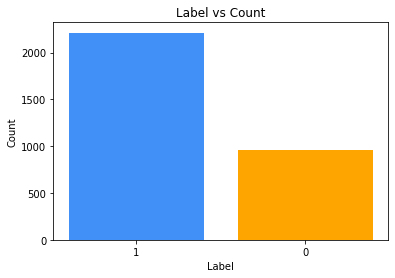

In [ ]:
class_count_0, class_count_1 = df2['label'].value_counts()

class_0 = df2[df2['label'] == 0]
class_1 = df2[df2['label'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

plot({1:class_1.shape[0],0:class_0.shape[0]})

### Train and Test Split


In [ ]:
print(X_train.shape)

(2379, 3)


In [ ]:
print(X_test.shape)

(794, 3)


Counter({1: 1663, 0: 716})



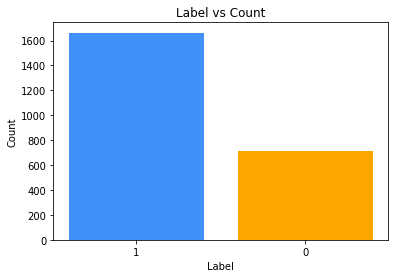

In [ ]:
print(Counter(y_train))
print()
plot(dict(Counter(y_train)))

Counter({1: 1663, 0: 1496})



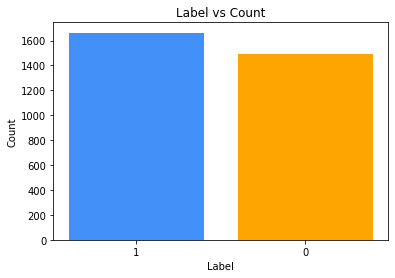

In [ ]:
print(Counter(y_train_SMOTE))
print()
plot(dict(Counter(y_train_SMOTE)))

In [ ]:
X = df_test.drop(columns = ['caption' , 'caption_bert' , 'comment', 'comment_bert' , 'post_number' ])

In [ ]:
X

,cosine_simarlity,Semantic_Similarity,Bert_Similarity
0,0.000000,0.696754,0.807585
1,0.000000,0.601199,0.727608
2,0.000000,0.549590,0.776446
3,0.000000,0.616660,0.880202
4,0.000000,0.746787,0.617682
...,...,...,...
3375,0.000000,0.537883,0.603066
3376,0.143628,0.778559,0.854376
3377,0.000000,0.530218,0.772193
3378,0.000000,0.819098,0.872638


In [ ]:
rfc_predict_test = rfc.predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
df_test['label'] = rfc_predict_test

In [ ]:
df_test['label'].value_counts()

1    3227
0     153
Name: label, dtype: int64

In [ ]:
df_test.loc[df_test['label'] == 0]

,post_number,caption,caption_bert,comment,comment_bert,cosine_simarlity,Semantic_Similarity,Bert_Similarity,label
4,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,सैकड़ों की भीड़ में सिर्फ,सैकड़ों की भीड़ में सिर्फ,0.000000,0.746787,0.617682,0
14,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,जय जय श्री राम,जय जय श्री राम,0.000000,0.242705,0.427801,0
73,8,गुजरात के हिम्मतनगर में फिर भड़की हिंसा लोगों को हिरासत में लिया गयागुजरात के साबरकांठा ज़िले के अधिकारियों ने समाचार एजेंसी पीटीआई को बताया कि दो अलगअलग समुदायों के बीच पत्थरबाज़ी शुरू होने के बाद हिंसा छिड़ी सोशल मीडिया पर शेयर किए कुछ वीडियो में कई लोग पेट्रोल बम फेंकते दिख रहे हैंएसपी विशालकुमार वघेला के अनुसार ये छोटीमोटी झड़प थी उन्होंने कहा झड़प की जानकारी मिलते ही हम मौके पर पहुंचे मामला छोटा था और हमने कुछ ही देर में स्थिति पर काबू पा लिया इससे पहले रविवार को हिम्मतनगर में राम नवमी की शोभा यात्रा के दौरान पत्थर फेंकने की वजह से हिंसा छिड़ी थी स्थिति को नियंत्रित करने के लिए डीएम ने सीआरपीसी की धारा लगाई थी,गुजरात के हिम्मतनगर में फिर भड़की हिंसा लोगों को हिरासत में लिया गयागुजरात के साबरकांठा ज़िले के अधिकारियों ने समाचार एजेंसी पीटीआई को बताया कि दो अलगअलग समुदायों के बीच पत्थरबाज़ी शुरू होने के बाद हिंसा छिड़ी सोशल मीडिया पर शेयर किए कुछ वीडियो में कई लोग पेट्रोल बम फेंकते दिख रहे हैंएसपी विशालकुमार वघेला के अनुसार ये छोटीमोटी झड़प थी उन्होंने कहा झड़प की जानकारी मिलते ही हम मौके पर पहुंचे मामला छोटा था और हमने कुछ ही देर में स्थिति पर काबू पा लिया इससे पहले रविवार को हिम्मतनगर में राम नवमी की शोभा यात्रा के दौरान पत्थर फेंकने की वजह से हिंसा छिड़ी थी स्थिति को नियंत्रित करने के लिए डीएम ने सीआरपीसी की धारा लगाई थी,इस्लाम ने भारत मै दंगे कराने के लिए पाकिस्तान मै दिन पहले मिटीग रखी थी यह उसी का नतीजा है,इस्लाम ने भारत मै दंगे कराने के लिए पाकिस्तान मै दिन पहले मिटीग रखी थी । यह उसी का नतीजा है ।,0.022325,0.863130,0.932510,0
94,8,गुजरात के हिम्मतनगर में फिर भड़की हिंसा लोगों को हिरासत में लिया गयागुजरात के साबरकांठा ज़िले के अधिकारियों ने समाचार एजेंसी पीटीआई को बताया कि दो अलगअलग समुदायों के बीच पत्थरबाज़ी शुरू होने के बाद हिंसा छिड़ी सोशल मीडिया पर शेयर किए कुछ वीडियो में कई लोग पेट्रोल बम फेंकते दिख रहे हैंएसपी विशालकुमार वघेला के अनुसार ये छोटीमोटी झड़प थी उन्होंने कहा झड़प की जानकारी मिलते ही हम मौके पर पहुंचे मामला छोटा था और हमने कुछ ही देर में स्थिति पर काबू पा लिया इससे पहले रविवार को हिम्मतनगर में राम नवमी की शोभा यात्रा के दौरान पत्थर फेंकने की वजह से हिंसा छिड़ी थी स्थिति को नियंत्रित करने के लिए डीएम ने सीआरपीसी की धारा लगाई थी,गुजरात के हिम्मतनगर में फिर भड़की हिंसा लोगों को हिरासत में लिया गयागुजरात के साबरकांठा ज़िले के अधिकारियों ने समाचार एजेंसी पीटीआई को बताया कि दो अलगअलग समुदायों के बीच पत्थरबाज़ी शुरू होने के बाद हिंसा छिड़ी सोशल मीडिया पर शेयर किए कुछ वीडियो में कई लोग पेट्रोल बम फेंकते दिख रहे हैंएसपी विशालकुमार वघेला के अनुसार ये छोटीमोटी झड़प थी उन्होंने कहा झड़प की जानकारी मिलते ही हम मौके पर पहुंचे मामला छोटा था और हमने कुछ ही देर में स्थिति पर काबू पा लिया इससे पहले रविवार को हिम्मतनगर में राम नवमी की शोभा यात्रा के दौरान पत्थर फेंकने की वजह से हिंसा छिड़ी थी स्थिति को नियंत्रित करने के लिए डीएम ने सीआरपीसी की धारा लगाई थी,अब येही हिंसा है जिस के सहारे सत्ता तक पाहोचना चाहती है क्यूँ की काम तो कुछ किया नही,अब येही हिंसा है जिस के सहारे सत्ता तक पाहोचना चाहती है क्यूँ की काम तो कुछ किया नही,0.023979,0.864781,0.859462,0
96,8,गुजरात के हिम्मतनगर में फिर भड़की हिंसा लोगों को हिरासत में लिया गयागुजरात के साबरकांठा ज़िले के अधिकारियों ने समाचार एजेंसी पीटीआई को बताया कि दो अलगअलग समुदायों के बीच पत्थरबाज़ी शुरू होने के बाद हिंसा छिड़ी सोशल मीडिया पर शेयर किए कुछ वीडियो में कई लोग पेट्रोल बम फेंकते दिख रहे हैंएसपी विशालकुमार वघेला के अनुसार ये छोटीमोटी झड़प थी उन्होंने कहा झड़प की जानकारी मिलते ही हम मौके पर पहुंचे मामला छोटा था और हमने कुछ ही देर में स्थिति पर काबू पा लिया इससे पहले

In [ ]:
df_test.loc[df_test['label'] == 1]

,post_number,caption,caption_bert,comment,comment_bert,cosine_simarlity,Semantic_Similarity,Bert_Similarity,label
0,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,उसने किसी को पत्थर नहीं मारा किसी पर बम नहीं फेंका किसी को अपशब्द बोले किसी का घर जलाया तो फिर सजा किस बात की,उसने किसी को पत्थर नहीं मारा किसी पर बम नहीं फेंका न किसी को अपशब्द बोले न किसी का घर जलाया तो फिर सजा किस बात की,0.000000,0.696754,0.807585,1
1,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,कानून इस पर कार्यवाही करेगा,कानून इस पर कार्यवाही करेगा,0.000000,0.601199,0.727608,1
2,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,फांसी की सज़ा मिलनी चाहिए कुत्ते को,फांसी की सज़ा मिलनी चाहिए कुत्ते को,0.000000,0.549590,0.776446,1
3,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,देशद्रोह का केस होना चाहिए जितने लोग उसमे शामिल है,देशद्रोह का केस होना चाहिए जितने लोग उसमे शामिल है,0.000000,0.616660,0.880202,1
5,1,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,बिहार मुज़फ़्फ़रपुर की मस्जिद में भगवा झंडा फहराने के मामले में तीन गिरफ़्तारपूरी स्टोरी,इस के घर भी बुलडोजर चलाओ,इस के घर भी बुलडोजर चलाओ । ।,0.000000,0.593351,0.691272,1
...,...,...,...,...,...,...,...,...,...
3375,91,राहुल गांधी को मायावती का जवाब पहले अपनी पार्टी संभालेंपूरी स्टोरी,राहुल गांधी को मायावती का जवाब पहले अपनी पार्टी संभालेंपूरी स्टोरी,बीजेपी आरएसएस की एजेंट,बीजेपी आरएसएस की एजेंट,0.000000,0.537883,0.603066,1
3376,92,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,बाजपेई एक नेक इंसान थे भाईचारे के लिए देश सदैव उनको याद करेगा,बाजपेई एक नेक इंसान थे । भाईचारे के लिए देश सदैव उनको याद करेगा ।,0.143628,0.778559,0.854376,1
3377,92,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,बीबीसी चरमपंथी संगठन की नौटंकी,बीबीसी चरमपंथी संगठन की नौटंकी,0.000000,0.530218,0.772193,1
3378,92,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,अटल बिहारी वाजपेयी के उन किस्सों की चर्चा जिसके बारे में कम लोगों को जानकारी है वाजपेयी प्यार को प्यार ही रहने दो कोई नाम न दो,इमरान जी आपको आने वाले वर्षों में पांचवी निकाह की बहुतबहुत शुभकामनाएं और सबसे पहली बात आपने घबराना नहीं है,इमरान जी आपको आने वाले वर्षों में पांचवी निकाह की बहुतबहुत शुभकामनाएं और सबसे पहली बात आपने घबराना नहीं है,0.000000,0.819098,0.872638,1


In [ ]:
df_test

In [ ]:
df2

,label,cosine_simarlity,Semantic_Similarity,Bert_Similarity
0,1,0.000000,0.803942,0.867306
1,1,0.037137,0.823443,0.883859
2,0,0.000000,0.880556,0.904320
3,0,0.131486,0.858215,0.886201
4,0,0.058141,0.722807,0.851685
...,...,...,...,...
3168,1,0.107708,0.920567,0.825135
3169,1,0.107708,0.920567,0.825135
3170,1,0.107708,0.920567,0.825135
3171,1,0.319454,0.870967,0.834763


In [ ]:
def get_scores( feature_to_drop , df2 ):

    X_train, X_test, y_train, y_test = train_test_split(df2.drop(feature_to_drop,axis=1),df2['label'], test_size=0.25,random_state=101)
    scale=StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)


    print("\nBefore oversampling: ",dict(Counter(y_train)))

    smote = SMOTE(random_state=42, sampling_strategy=0.9)
    X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

    print("\nAfter oversampling: ",dict(Counter(y_train_SMOTE)))


    rfc = RandomForestClassifier()
    rfc.fit(X_train_SMOTE, y_train_SMOTE)
    rfc_predict = rfc.predict(X_test)

    matrix = confusion_matrix(y_test,rfc_predict, labels=[1,0])
    print('\nConfusion matrix : \n',matrix)

    tp, fn, fp, tn = confusion_matrix(y_test,rfc_predict,labels=[1,0]).reshape(-1)

    print( '\nTrue_pos : ', tp)
    print( '\nTrue_neg : ', tn)
    print( '\nFalse_pos : ', fp)
    print( '\nFalse_neg : ', fn)

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1_score = (2*recall*precision)/(recall+precision)

    print( '\nAccuracy =' , accuracy )
    print('\nRecall = ' , recall )
    print('\nPrecision = ' , precision )
    print('\nF1_score = ' , f1_score)

In [ ]:
# Word2vec and Bert
get_scores( ['label','cosine_simarlity'] , df2 )


Before oversampling:  {1: 1663, 0: 716}

After oversampling:  {1: 1663, 0: 1496}

Confusion matrix : 
 [[366 183]
 [137 108]]

True_pos :  366

True_neg :  108

False_pos :  137

False_neg :  183

Accuracy = 0.5969773299748111

Recall =  0.6666666666666666

Precision =  0.7276341948310139

F1_score =  0.6958174904942965


In [ ]:
# Cosine and Bert
get_scores( ['label','Semantic_Similarity'] , df2 )


Before oversampling:  {1: 1663, 0: 716}

After oversampling:  {1: 1663, 0: 1496}

Confusion matrix : 
 [[379 170]
 [136 109]]

True_pos :  379

True_neg :  109

False_pos :  136

False_neg :  170

Accuracy = 0.6146095717884131

Recall =  0.6903460837887068

Precision =  0.7359223300970874

F1_score =  0.7124060150375939


In [ ]:
# Cosine and Word2vec
get_scores( ['label','Bert_Similarity'] , df2 )


Before oversampling:  {1: 1663, 0: 716}

After oversampling:  {1: 1663, 0: 1496}

Confusion matrix : 
 [[375 174]
 [131 114]]

True_pos :  375

True_neg :  114

False_pos :  131

False_neg :  174

Accuracy = 0.6158690176322418

Recall =  0.6830601092896175

Precision =  0.741106719367589

F1_score =  0.7109004739336493


In [ ]:
#only cosine
get_scores(['label','Bert_Similarity','Semantic_Similarity'] , df2)


Before oversampling:  {1: 1663, 0: 716}

After oversampling:  {1: 1663, 0: 1496}

Confusion matrix : 
 [[221 328]
 [ 59 186]]

True_pos :  221

True_neg :  186

False_pos :  59

False_neg :  328

Accuracy = 0.5125944584382871

Recall =  0.40255009107468126

Precision =  0.7892857142857143

F1_score =  0.5331724969843186


In [ ]:
#only semantic
get_scores(['label','cosine_simarlity','Bert_Similarity'] , df2)


Before oversampling:  {1: 1663, 0: 716}

After oversampling:  {1: 1663, 0: 1496}

Confusion matrix : 
 [[332 217]
 [124 121]]

True_pos :  332

True_neg :  121

False_pos :  124

False_neg :  217

Accuracy = 0.570528967254408

Recall =  0.604735883424408

Precision =  0.7280701754385965

F1_score =  0.6606965174129353


In [ ]:
# Only BERT
get_scores(['label','cosine_simarlity','Semantic_Similarity'] , df2)


Before oversampling:  {1: 1663, 0: 716}

After oversampling:  {1: 1663, 0: 1496}

Confusion matrix : 
 [[318 231]
 [145 100]]

True_pos :  318

True_neg :  100

False_pos :  145

False_neg :  231

Accuracy = 0.5264483627204031

Recall =  0.5792349726775956

Precision =  0.6868250539956804

F1_score =  0.6284584980237155


In [ ]:
#with all features
get_scores(['label'] , df2)


Before oversampling:  {1: 1663, 0: 716}

After oversampling:  {1: 1663, 0: 1496}

Confusion matrix : 
 [[402 147]
 [153  92]]

True_pos :  402

True_neg :  92

False_pos :  153

False_neg :  147

Accuracy = 0.6221662468513854

Recall =  0.73224043715847

Precision =  0.7243243243243244

F1_score =  0.7282608695652174


In [ ]:
# json_data_file =open('HindiDataset.json','w',encoding='utf-8')

# json_data_file.write('[')

In [ ]:
# class SetEncoder(json.JSONEncoder):
#   def default(self, obj):
#     if isinstance(obj, set):
#       return list(obj)
#     return json.JSONEncoder.default(self, obj)

In [ ]:
# def iterate_all_captions_and_comments(total_posts,total_comments):
#     for index in range(61,len(caption_comments_replies)-30):  
#         # caption,comments = get_captions_and_comments(index)
#         data = {}
#         caption = caption_comments_replies[index]['content']
#         comments = caption_comments_replies[index]['comments_and_replies']
        
#         data['content'] = caption
#         data["comments_and_replies"]= []

#         comments_and_replies = []

    
#         for i in comments:
#             dict_each = {}
#             clean_comment_bert = ' '.join( [word for word in preprocess_text_bert(i['comment'])] )
#             clean_caption_bert = ' '.join( [word for word in preprocess_text_bert(caption)])

#             clean_comment = ' '.join( [word for word in preprocess_text(i['comment'])] )
#             clean_caption = ' '.join( [word for word in preprocess_text(caption)])

#             sim = (
#                 abs(bert_similarity(clean_caption_bert,clean_comment_bert,20))+
#                       abs(calculate_semantic_similarity(clean_caption,clean_comment,'fasttext',300))) /2
            
#             print(sim)

#             if sim<0.5:
#                 i['related'] = 0
#             dict_each['comment'] = i['comment']
#             dict_each['commenter_name'] = i['commenter_name']
#             dict_each['related'] = i['related']
#             dict_each['replies'] = []
#             for j in i['replies']:
#                 for k in list(j.keys()):

#                     clean_comment = ' '.join( [word for word in preprocess_text(k)] )

#                     simi = (abs(bert_similarity(clean_caption_bert,clean_comment_bert,20))+
#                       abs(calculate_semantic_similarity(clean_caption,clean_comment,'fasttext',300)))/2
#                     print(simi,'df')

#                     if simi<0.5:
#                         dict_each['replies'].append({k:0})
#                     else:
#                         dict_each['replies'].append({k:1})
#             # print(repl)
  
#             # print(dict_each)
#             data["comments_and_replies"].append(dict_each)

#         # json_object = json.dump(data, json_data_file,cls=SetEncoder,ensure_ascii=False)
#         # json_data_file.write(',')


# iterate_all_captions_and_comments(total_posts=0,total_comments=0)
# # json_data_file.write(']')
# # json_data_file.close()